In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import xarray as xr
import pandas as pd
import pytz
from datetime import datetime as dt
from datetime import timedelta, timezone
import sys,os,glob
import IPython
from matplotlib import cm
import matplotlib.image as mpimg
from math import ceil,e,pi
from scipy.constants import Stefan_Boltzmann
from scipy.optimize import curve_fit
from math import log,exp
import pickle

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

In [2]:
workdir = os.getcwd()
rootdir = os.path.dirname(workdir)
figdir = os.path.join(rootdir,'figures','proxyQradPeakFromMoistureProfile')
if not os.path.exists(figdir): os.makedirs(figdir)
resultdir = os.path.join(rootdir,'results','proxyQradPeakFromMoistureProfile')
if not os.path.exists(resultdir): os.makedirs(resultdir)

In [3]:
moduledir = os.path.join(rootdir,'functions')

# inputdir = os.path.join(repodir,'input/irene')

# Load own module
projectname = 'EUREC4A_organization'
while os.path.basename(rootdir) != projectname:
    rootdir = os.path.dirname(rootdir)
thismodule = sys.modules[__name__]
## Own functions

sys.path.insert(0,moduledir)

from conditionalstats import *
from matrixoperators import *

In [4]:
day = '20200126'
# day = '20200131'
# day = '20200202'
date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))

lat_box = 11,16
lon_box = -60,-52

lat_box_goes = 10,16
lon_box_goes = -60,-52

In [5]:
indir_sonde_qrad = '/Users/bfildier/Dropbox/Data/EUREC4A/sondes_radiative_profiles/'
indir_goes_images = '/Users/bfildier/Data/satellite/GOES/images/%s'%date.strftime('%Y_%m_%d')

In [6]:
print('load rad profiles')
# radprf = xr.open_dataset(os.path.join(indir_sonde_qrad,'rad_profiles.nc'))
radprf = xr.open_dataset(os.path.join(indir_sonde_qrad,'rad_profiles_CF.nc'))

load rad profiles


In [7]:
print("remove profiles with missing data and select current day")

data_day = radprf.where(radprf.z_min<=50,drop=True).sel(launch_time=day)

remove profiles with missing data and select current day


In [8]:
print("Load radiative features")

features_filename = 'rad_features.pickle'
features_path = os.path.join(os.path.dirname(resultdir),'radiative_features',day,features_filename)
features = pickle.load(open(features_path,'rb'))

Load radiative features


# Integrated water vapor vs. T

In [9]:
mo = MatrixOperators()

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


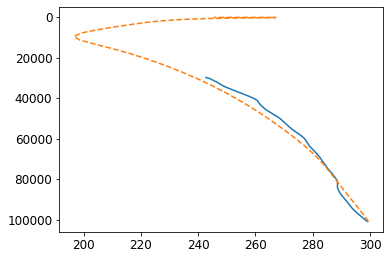

In [22]:
# background tropical atmosphere
background_file = "/Users/bfildier/Code/analyses/EUREC4A/EUREC4A_rad_profiles/input/tropical-atmosphere.nc"
tropical_atmosphere = xr.open_dataset(background_file)

# sounding data
pres = np.mean(data_day.pressure,axis=0)/100 # hPa
temp = np.nanmean(data_day.temperature,axis=0)

fig,ax = plt.subplots()
ax.plot(temp,pres*1e2)
ax.plot(tropical_atmosphere.t_lay,tropical_atmosphere.p_lay,'--')
ax.invert_yaxis()


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


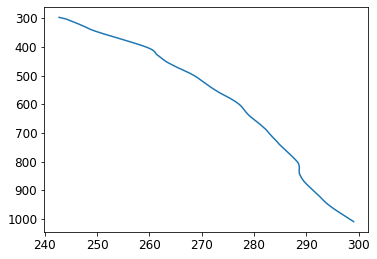

In [16]:
tropical_atmosphere.t_lay.interp()

In [11]:
print("compute integrated water path above")

iwp_above = np.full(data_day.specific_humidity.shape,np.nan)
Nz = data_day.dims['alt']

for i_z in range(Nz-2):
    iwp_above[:,i_z] = mo.pressureIntegral(arr=data_day.specific_humidity[:,i_z:],pres=pres[i_z:],p_levmin=pres[i_z],p_levmax=pres[-1],z_axis=1)


compute integrated water path above


In [12]:
print("calculate PW with humidity data saved in rad profiles")

def computePW(data):

    # qv
    qv = data.specific_humidity.values
    # density
    t_lay = data.temperature.values
    R = 287 # J/kg/K
    p_lay = data.pressure.values
    rho_lay = p_lay/(R*t_lay)
    # dz
    dz = np.diff(data.alt_edges)
    dz_3D = np.repeat(dz[np.newaxis,:],t_lay.shape[0],axis=0)
    # PW
    pw = np.nansum(qv[:,:-2]*rho_lay[:,:-2]*dz_3D,axis=1)
    
    return pw

pw = computePW(data_day)

calculate PW with humidity data saved in rad profiles


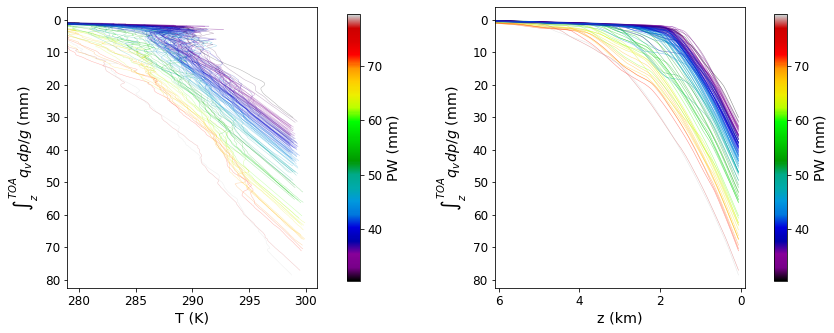

In [13]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

Ns = data_day.dims['launch_time']

# colors
var_col = pw
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col)) 

##--- IWP as a function of T

ax = axs[0]

for i_s in range(Ns):
    ax.plot(data_day.temperature[i_s],iwp_above[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)
    
ax.invert_yaxis()
ax.set_xlim((279,301))
ax.set_xlabel('T (K)')
ax.set_ylabel(r'$\int_z^{TOA} q_v dp/g$ (mm)')

#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label('PW (mm)')

##--- IWP as a function of z

ax = axs[1]

for i_s in range(Ns):
    ax.plot(data_day.alt/1e3,iwp_above[i_s],c=cols[i_s],linewidth=0.5,alpha=0.5)
    
ax.invert_yaxis()
ax.set_xlim((-0.1,6.1))
ax.invert_xaxis()
ax.set_xlabel('z (km)')
ax.set_ylabel(r'$\int_z^{TOA} q_v dp/g$ (mm)')

#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label('PW (mm)')

plt.savefig(os.path.join(figdir,'IWP_above_vs_T_and_z_colorPW_%s.pdf'%date.strftime("%Y%m%d")),bbox_inches='tight')
plt.savefig(os.path.join(figdir,'IWP_above_vs_T_and_z_colorPW_%s.png'%date.strftime("%Y%m%d")),bbox_inches='tight')

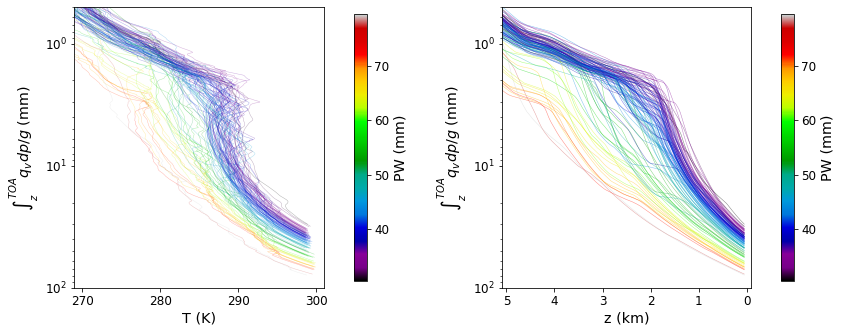

In [14]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

Ns = data_day.dims['launch_time']

# colors
var_col = pw
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col)) 

##--- IWP as a function of T

ax = axs[0]

for i_s in range(Ns):
    ax.plot(data_day.temperature[i_s],iwp_above[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)
    
ax.set_yscale('log')
ax.set_ylim((0.5,100))
ax.invert_yaxis()
ax.set_xlim((269,301))
ax.set_xlabel('T (K)')
ax.set_ylabel(r'$\int_z^{TOA} q_v dp/g$ (mm)')

#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label('PW (mm)')

##--- IWP as a function of z

ax = axs[1]

for i_s in range(Ns):
    ax.plot(data_day.alt/1e3,iwp_above[i_s],c=cols[i_s],linewidth=0.5,alpha=0.5)
    
ax.set_yscale('log')
ax.set_ylim((0.5,100))
ax.invert_yaxis()
ax.set_xlim((-0.1,5.1))
ax.invert_xaxis()
ax.set_xlabel('z (km)')
ax.set_ylabel(r'$\int_z^{TOA} q_v dp/g$ (mm)')

#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label('PW (mm)')

plt.savefig(os.path.join(figdir,'IWP_logaxis_above_vs_T_and_z_colorPW_%s.pdf'%date.strftime("%Y%m%d")),bbox_inches='tight')
plt.savefig(os.path.join(figdir,'IWP_logaxis_above_vs_T_and_z_colorPW_%s.png'%date.strftime("%Y%m%d")),bbox_inches='tight')

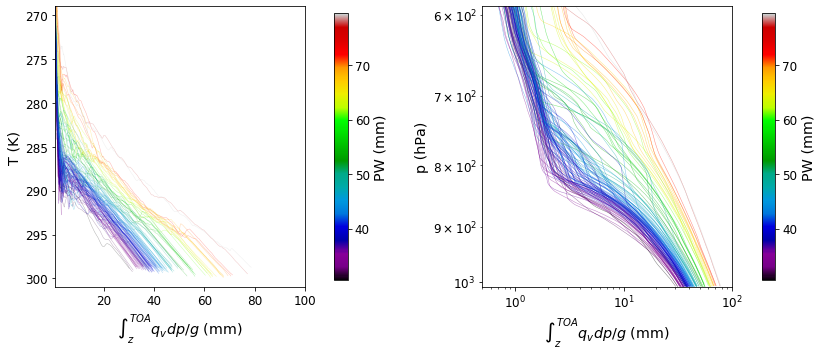

In [15]:
##-- WP profile in T z space

fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

Ns = data_day.dims['launch_time']

pres = data_day.pressure/100
temp = data_day.temperature

# colors
var_col = pw
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col)) 

#- WP profile in T space

ax = axs[0]

for i_s in range(Ns):
    ax.plot(iwp_above[i_s],temp[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)

# ax.set_yscale('log')
ax.set_xlim((0.5,100))
ax.set_xlabel(r'$\int_z^{TOA} q_v dp/g$ (mm)')
ax.set_ylim((269,301))
ax.invert_yaxis()
ax.set_ylabel('T (K)')


#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label('PW (mm)')

#- WP profile in p space (log-log)

ax = axs[1]

for i_s in range(Ns):
    ax.plot(iwp_above[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,100))
ax.set_ylim((590,1010))
ax.invert_yaxis()
# ax.invert_xaxis()
ax.set_ylabel('p (hPa)')
ax.set_xlabel(r'$\int_z^{TOA} q_v dp/g$ (mm)')

#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label('PW (mm)')

plt.savefig(os.path.join(figdir,'WPz_profile_in_T_z_space_colorPW_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')
plt.savefig(os.path.join(figdir,'WPz_profile_in_T_z_space_colorPW_%s.png'%date.strftime("%Y%m%d")),bbox_inches='tight')


## Beta coefficient

In Jeevanjee & Fueglistaler (2019)

$$ \beta = \frac{\partial \ln \tau}{\partial \ln p} $$

Here we simplify

$$ \tau \approx \kappa W $$ where $ W = \int_0^p q_v \frac{dp}{g} $ is the integrated water vapor above pressure level p

and compute beta as:

$$ \beta = \frac{\partial \ln W}{\partial \ln p} $$

Then 

In [16]:
#- beta coefficient (=dln(tau) / dln(p), Jeevanjee Fueglistaler 2019) and beta/p profiles in p space

ln_wpz = np.log(iwp_above)
ln_p = np.log(pres)
ln_p_mean = np.nanmean(ln_p,axis=0)

beta,_ = mo.derivative(ln_wpz,ln_p_mean,axis=1)

transmittivity_coef = -beta/pres

def estimatedFluxDivergence(W,temp,pres,beta,emissivity=0.9,extinction_coef=0.2):
    
    planck = pi*emissivity*Stefan_Boltzmann*(temp**4)
    tau = extinction_coef*W
    
    return -planck*beta/pres*tau*np.exp(-tau)


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


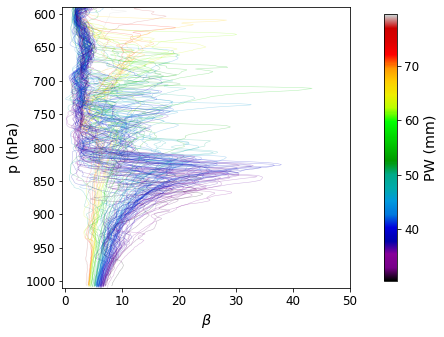

In [18]:
##-- beta coefficient (=dln(tau) / dln(p), Jeevanjee Fueglistaler 2019) in p space

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))

Ns = data_day.dims['launch_time']

pres = data_day.pressure/100

# colors
var_col = pw
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col))




for i_s in range(Ns):
    ax.plot(beta[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)

# ax.set_yscale('log')
ax.set_xlim((-0.5,50))
ax.set_xlabel(r'$\beta$')
ax.set_ylim((590,1010))
ax.invert_yaxis()
ax.set_ylabel('p (hPa)')

#- colorbar
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
             ax=ax,shrink=0.95,pad=0.09)
cb.set_label('PW (mm)')

plt.savefig(os.path.join(figdir,'beta_profile_in_p_space_colorPW_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')
plt.savefig(os.path.join(figdir,'beta_profile_in_p_space_colorPW_%s.png'%date.strftime("%Y%m%d")),bbox_inches='tight')


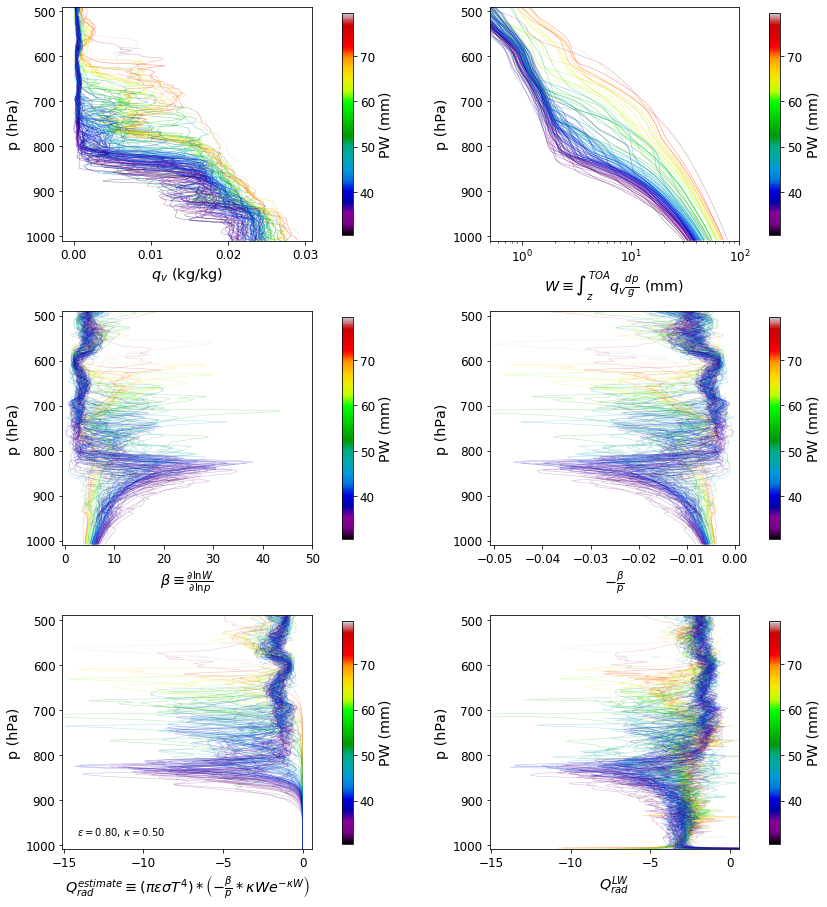

In [18]:
##-- Show qv, wp_z, beta, -1/e beta/p, -pi sigma T^4 1/e beta/p, Qrad

fig,axs = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

Ns = data_day.dims['launch_time']

pres = data_day.pressure/100

# colors
var_col = pw
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col))


#---- qv

ax = axs[0,0]

for i_s in range(Ns):
    ax.plot(data_day.specific_humidity[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.5)

# ax.set_xlim((0.5,100))
ax.set_xlabel(r'$q_v$ (kg/kg)')

#---- water path above level

ax = axs[0,1]

for i_s in range(Ns):
    ax.plot(iwp_above[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.5)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim((0.5,100))
ax.set_xlabel(r'$W \equiv \int_z^{TOA} q_v \frac{dp}{g}$ (mm)')

#---- beta

ax = axs[1,0]

for i_s in range(Ns):
    ax.plot(beta[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)

# ax.set_yscale('log')
ax.set_xlim((-0.5,50))
ax.set_xlabel(r'$\beta \equiv \frac{\partial \ln W}{\partial \ln p}$')

#---- -1/e beta/p

ax = axs[1,1]

for i_s in range(Ns):
    ax.plot(transmittivity_coef[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)

# ax.set_yscale('log')
ax.set_xlim((-0.051,0.001))
ax.set_xlabel(r'$-\frac{\beta}{p}$')

#---- pi sigma T^4 beta/p

ax = axs[2,0]

# compute
emissivity = 0.8
extinction_coef = 0.5
estimated_QRAD = estimatedFluxDivergence(iwp_above,temp,pres,beta,emissivity,extinction_coef)

for i_s in range(Ns):
    ax.plot(estimated_QRAD[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)

ax.text(x=0.06,y=0.06,s=r'$\varepsilon = %1.2f$, $\kappa = %1.2f$'%(emissivity,extinction_coef),transform=ax.transAxes)
    
# ax.set_yscale('log')
ax.set_xlim((-15.1,0.6))
ax.set_xlabel(r'$Q_{rad}^{estimate} \equiv \left(\pi\varepsilon\sigma T^4\right)*\left(-\frac{\beta}{p}*\kappa W e^{-\kappa W}\right)$')

#---- Qrad

ax = axs[2,1]

for i_s in range(Ns):
    ax.plot(data_day.q_rad_lw[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)

# ax.set_yscale('log')
ax.set_xlim((-15.1,0.6))
ax.set_xlabel(r'$Q_{rad}^{LW}$')


for ax in axs.flatten():

    #- all y axes
    ax.set_ylim((490,1010))
    ax.invert_yaxis()
    ax.set_ylabel('p (hPa)')

    #- all colorbars
    cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
                 ax=ax,shrink=0.95,pad=0.09)
    cb.set_label('PW (mm)')
    
    
plt.savefig(os.path.join(figdir,'proxy_QRADLW_profile_all_steps_colorPW_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')
plt.savefig(os.path.join(figdir,'proxy_QRADLW_profile_all_steps_colorPW_%s.png'%date.strftime("%Y%m%d")),bbox_inches='tight')


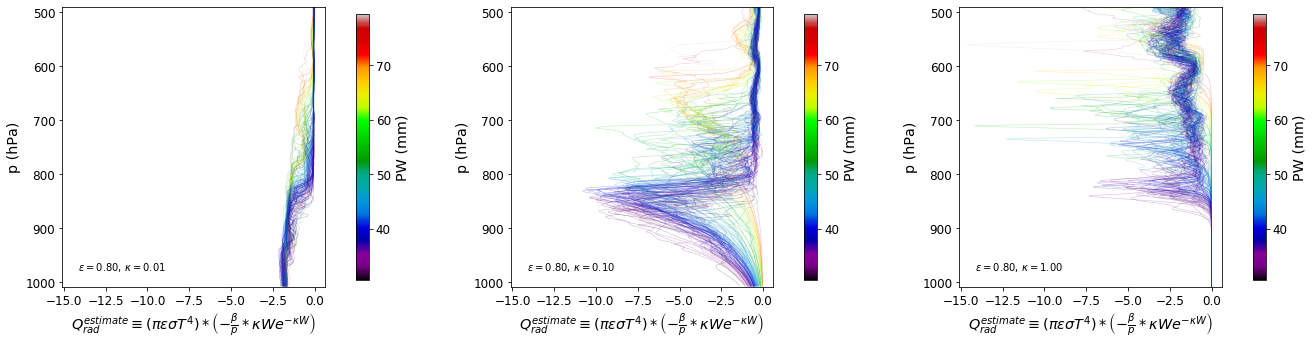

In [19]:
##-- Show Qrad_est for different values of kappa ## TODO

fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(23,5))

Ns = data_day.dims['launch_time']

pres = data_day.pressure/100

# colors
var_col = pw
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col))

extinction_coefs = 0.01,0.1,1
emissivity = 0.8

for ax,extinction_coef in zip(axs.flatten(),extinction_coefs):

    # compute
    estimated_QRAD = estimatedFluxDivergence(iwp_above,temp,pres,beta,emissivity,extinction_coef)

    for i_s in range(Ns):
        ax.plot(estimated_QRAD[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)

    ax.text(x=0.06,y=0.06,s=r'$\varepsilon = %1.2f$, $\kappa = %1.2f$'%(emissivity,extinction_coef),transform=ax.transAxes)

    # ax.set_yscale('log')
    ax.set_xlim((-15.1,0.6))
    ax.set_xlabel(r'$Q_{rad}^{estimate} \equiv \left(\pi\varepsilon\sigma T^4\right)*\left(-\frac{\beta}{p}*\kappa W e^{-\kappa W}\right)$')

for ax in axs.flatten():

    #- all y axes
    ax.set_ylim((490,1010))
    ax.invert_yaxis()
    ax.set_ylabel('p (hPa)')

    #- all colorbars
    cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),
                 ax=ax,shrink=0.95,pad=0.09)
    cb.set_label('PW (mm)')


plt.savefig(os.path.join(figdir,'proxy_QRADLW_profile_various_kappa_colorPW_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')
plt.savefig(os.path.join(figdir,'proxy_QRADLW_profile_various_kappa_colorPW_%s.png'%date.strftime("%Y%m%d")),bbox_inches='tight')


### What is the shape of $\tau e^{-\tau}$ ?

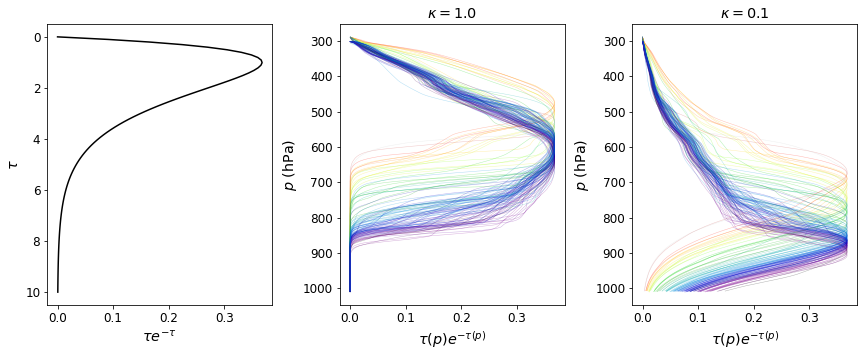

In [20]:


Ns = data_day.dims['launch_time']

# colors
var_col = pw
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col))

fig,axs = plt.subplots(ncols=3,figsize=(15,5))

##-- tau*exp(-tau) vs. tau

tau = np.linspace(0,10,100)
dTransdtau = tau*np.exp(-tau)

ax = axs[0]

ax.plot(dTransdtau,tau,'k')

ax.invert_yaxis()
ax.set_xlabel(r'$\tau e^{-\tau}$')
ax.set_ylabel(r'$\tau$')

##-- tau(p)*exp(-tau(p)) vs. p, kappa=1

extinction_coef = 1
tau = extinction_coef*iwp_above
tau_exp_mtau = tau*np.exp(-tau)
pres = data_day.pressure/100

ax = axs[1]

for i_s in range(Ns):
    ax.plot(tau_exp_mtau[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)

ax.invert_yaxis()
ax.set_xlabel(r'$\tau(p) e^{-\tau(p)}$')
ax.set_ylabel(r'$p$ (hPa)')
ax.set_title(r'$\kappa = $%1.1f'%extinction_coef)

##-- tau(p)*exp(-tau(p)) vs. p, kappa=0.1

extinction_coef = 0.1
tau = extinction_coef*iwp_above
tau_exp_mtau = tau*np.exp(-tau)
pres = data_day.pressure/100

ax = axs[2]

for i_s in range(Ns):
    ax.plot(tau_exp_mtau[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)

ax.invert_yaxis()
ax.set_xlabel(r'$\tau(p) e^{-\tau(p)}$')
ax.set_ylabel(r'$p$ (hPa)')
ax.set_title(r'$\kappa = $%1.1f'%extinction_coef)

plt.savefig(os.path.join(figdir,'tau_exp_mtau_various_kappa_colorPW_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')
plt.savefig(os.path.join(figdir,'tau_exp_mtau_various_kappa_colorPW_%s.png'%date.strftime("%Y%m%d")),bbox_inches='tight')


In [21]:
print("compute tau*exp(-tau) integrated over kappa")

# define wavenumbers in log space
k_min = 0.01 # min wavenumber
k_max = 1 # max wavenumber
ks = np.logspace(log10(k_min),log10(k_max),31)
ks_mids = np.convolve(ks,[0.5,0.5],mode='valid')
dks = np.diff(ks)

# initialize tau and tau*exp(-tau) arrays
tau_all = np.full((*iwp_above.shape,ks_mids.size),np.nan)
tau_exp_mtau_all = np.full((*iwp_above.shape,ks_mids.size),np.nan)

# compute
for i_k in range(len(ks_mids)):
    k = ks_mids[i_k]
    tau = k*iwp_above
    tau_all[:,:,i_k] = tau
    tau_exp_mtau_all[:,:,i_k] = tau*np.exp(-tau)

# sum over extinction coefficients
dks_2D = mo.duplicate(dks,(*iwp_above.shape,1),ref_axis=2)
int_tau_exp_mtau = np.nansum(tau_exp_mtau_all*dks_2D,axis=2)


compute tau*exp(-tau) integrated over kappa


show int_kappa tau*exp(-tau)


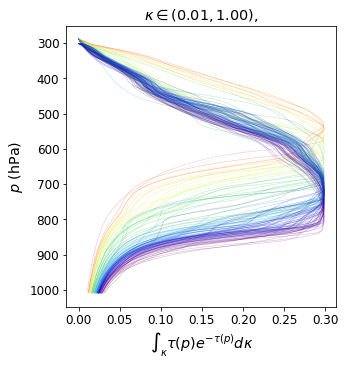

In [22]:
print("show int_kappa tau*exp(-tau)")

Ns = data_day.dims['launch_time']

# colors
var_col = pw
norm = matplotlib.colors.Normalize(vmin=var_col.min(), vmax=var_col.max())
cmap = plt.cm.nipy_spectral
cols = cmap(norm(var_col))

fig,ax = plt.subplots(ncols=1,figsize=(5,5))

##-- tau(p)*exp(-tau(p)) vs. p, kappa=0.1

pres = data_day.pressure/100

for i_s in range(Ns):
    ax.plot(int_tau_exp_mtau[i_s],pres[i_s],c=cols[i_s],linewidth=0.5,alpha=0.3)

ax.invert_yaxis()
ax.set_xlabel(r'$\int_\kappa\tau(p) e^{-\tau(p)} d\kappa$')
ax.set_ylabel(r'$p$ (hPa)')
ax.set_title(r'$\kappa \in (%1.2f,%1.2f)$,'%(k_min,k_max))

plt.savefig(os.path.join(figdir,'int_tau_exp_mtau_colorPW_%s.pdf'%(date.strftime("%Y%m%d"))),bbox_inches='tight')
plt.savefig(os.path.join(figdir,'int_tau_exp_mtau_colorPW_%s.png'%date.strftime("%Y%m%d")),bbox_inches='tight')


In [23]:
## Planck's function

def planck(nu,temp):
    
    h = 6.626e-34 # J.s
    kB = 1.381e-23 # J.K-1
    c = 2.998e8 # m.s-1
    
    planck = 2*h*nu**3*c**2/(np.exp(h*c*nu/kB/temp)-1) # J.s-1.sr-1.m-2.cm !
    
    return planck # recode to have vector inputs and ouput matrix

sigma T^4 = 459.29972699999996
150000.0
2 pi * B_nu (300K) * Delta nu = 459.6194474154956
emissivity = 1.0006961040834574


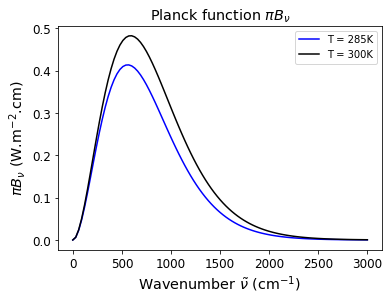

In [94]:
nu_inv_m = np.linspace(0.1,300000,101) # m-1
nu_inv_cm = nu_inv_m/1e2
B_nu_300 = planck(nu_inv_m,300)*1e2 # in W.sr-1.m-2.cm https://www.google.com/url?sa=i&url=https%3A%2F%2Fjournals.ametsoc.org%2Fview%2Fjournals%2Fatsc%2F69%2F6%2Fjas-d-11-0248.1.xml&psig=AOvVaw2s0ziov-IJRZKjs4HMPtp_&ust=1624635560046000&source=images&cd=vfe&ved=0CAsQjhxqFwoTCPjM7a_NsPECFQAAAAAdAAAAABAD
B_nu_285 = planck(nu_inv_m,285)*1e2 # in W.sr-1.m-2.cm
fig,ax = plt.subplots()

ax.plot(nu_inv_cm,pi*B_nu_285,'b',label='T = 285K')
ax.plot(nu_inv_cm,pi*B_nu_300,'k',label='T = 300K')

ax.set_xlabel(r'Wavenumber $\tilde{\nu}$ (cm$^{-1}$) ')
ax.set_ylabel(r'$\pi B_\nu$ (W.m$^{-2}$.cm)')
ax.set_title(r'Planck function $\pi B_\nu$')
ax.legend()

# sumulative sum
print('sigma T^4 =',Stefan_Boltzmann*300**4)
dnu = np.convolve(nu_inv_m,[0.5,-0.5],mode='same')
print(np.sum(dnu))
print('2 pi * B_nu (300K) * Delta nu =',np.sum(2*pi*B_nu_300/100*dnu))
print(r'emissivity =',(np.sum(2*pi*B_nu_300/100*dnu))/(Stefan_Boltzmann*300**4))

In [32]:
## test estimate of peak amplitude with simple expression

g = 9.81 # m/s
c_p = 1000 # J/kg
beta_peak = 40 # from graph above
p_peak = 80000 # Pa, from graph above
planck_term = 0.45 # W.m-2.cm from graph above
delta_nu = 39 # cm-1, estimated as l_rot*ln(2)
s_to_day = 1/(24*3600)

print()
print('estimate radiative cooling peak, assuming a wavenumber width of 39 cm-1')
print(-g/c_p*(beta_peak/p_peak)*planck_term*delta_nu/e/s_to_day,'K/day')

qrad_peak = 10 # K/day

print()
print("estimate delta nu from peak radiative cooling and expression")
delta_nu = qrad_peak/(-g/c_p*(beta_peak/p_peak)*planck_term/e/s_to_day)
print("delta_nu estimate =",delta_nu,'cm-1')


estimate radiative cooling peak, assuming a wavenumber width of 39 cm-1
-2.736121590532885 K/day

estimate delta nu from peak radiative cooling and expression
delta_nu estimate = -142.53752514121416 cm-1


Use Jeevanjee&Fueglistaler(2020) fit for $\kappa$ in the rotational band of water vapor:

$$\kappa(\nu) = \kappa_{rot}\exp\left(-\frac{\nu-\nu_{rot}}{l_{rot}}\right)$$

Estimate the width of extinction coefficients from the wavenumber width:

$$\frac{\kappa^*+\Delta \kappa}{\kappa^*} = \exp\left(-\frac{\Delta\nu}{l_{rot}}\right)$$
so 
$$\Delta \kappa = \kappa^*\left(\exp\left(-\frac{\Delta\nu}{l_{rot}}\right) -1 \right)$$
or 
$$\Delta \nu = l_{rot}\log\left(1 + \frac{\Delta\kappa}{\kappa^*} \right)$$

If we use expression above, with $\Delta \tau \approx 3$ (width of $\tau e^{-\tau}$) and $W^* = 3$ m2/kg, so $\Delta \kappa \approx 1 kg/m2$, we get:

In [30]:
print('- compute reference emitting wavenumber:')
nu_rot = 150 # cm-1
l_rot = 56 # cm-1
kappa_rot = 127 # m2.kg-1
W_star = 3  # mm, or kg.m-2
kappa_star = 1/W_star # m2.kg-1
nu_star = nu_rot + l_rot*log(kappa_rot/kappa_star) # cm-1
print('nu_star =',nu_star,'cm-1')
print()

print('- estimate wavenumber range and Qrad, assuming that it is constrained by the width of tau*exp(-tau)')
dkappa = 1 # kg.m-2
delta_nu_estimate = l_rot*log(1+dkappa/kappa_star)
print('delta_nu =',delta_nu_estimate,'cm-1')
qrad_estimate = -g/c_p*(beta_peak/p_peak)*planck_term*delta_nu_estimate/e/s_to_day
print('qrad_estimate =',qrad_estimate,'K/day')

- compute reference emitting wavenumber:
nu_star = 482.79676500709525 cm-1

- estimate wavenumber range and Qrad, assuming that it is constrained by the width of tau*exp(-tau)
delta_nu = 77.63248422271387 cm-1


NameError: name 'c_p' is not defined

In [32]:
print('Estimating Delta nu (from Delta tau = e)')
print(l_rot*log(1+e))

Estimating Delta nu from Delta tau = e
73.54265450102048


If we use $\Delta \nu$ estimate with expression above for $\Delta \kappa$:

In [34]:
print('estimate the range of optical depth emitting, from the peak radiative cooling observed')
delta_kappa = kappa_star*(exp(-delta_nu/l_rot)-1)
print('delta_kappa =',delta_kappa,'kg.m-2')
delta_tau = delta_kappa*W_star
print('delta_tau =',delta_tau,'')

estimate the range of optical depth emitting, from the peak radiative cooling observed
delta_kappa = 3.915738896666682 kg.m-2
delta_tau = 11.747216690000046 


# Linear regression of $Q_{rad}$ peak magnitude and $\beta$ using analytical expression

Simplification of the total cooling-to-space term gave:

$$\mathcal{H}^{CTS} \sim -\frac{g}{C_p}
    \frac{\beta^*}{p^*} \times \pi B_{\nu^*}(T^*) \times \frac{\Delta\nu}{e}$$
    
$$ \frac{m/s^2 \times J/s/m^2.cm \times cm^{-1}}{kg/m/s^2 \times J/kg/K} = K/s$$

In [106]:
g = 9.81 # m.s-2
c_p = 1000 # J/K/kg
m_to_cm = 1e2

nu_star_inv_m = nu_star*1e2 # cm-1

N_p = beta.shape[0]
# mask to discard profiles with small radiative peaks ?
keep_large_peaks = np.absolute(features.qrad_lw_peak) > 5

# beta term
beta_peak_all = np.full((N_p,),np.nan)
for i_p,i_z in zip(range(N_p),features.i_lw_peak):

    beta_peak_all[i_p] = beta[i_p,i_z]

# peak altitude
p_peak_all = np.full((N_p,),np.nan)
for i_p,i_z in zip(range(N_p),features.i_lw_peak):

    p_peak_all[i_p] = data_day.pressure.values[i_p,i_z]

# planck term
planck_peak_constant_all = np.full((N_p,),np.nan)
planck_peak_all = np.full((N_p,),np.nan)
for i_p,i_z in zip(range(N_p),features.i_lw_peak):

    # constant
    planck_peak_constant_all[i_p] = 0.45
    # T and nu dependent
    temp_peak = data_day.temperature.values[i_p,i_z]
    planck_peak_all[i_p] = pi*planck(nu_star_inv_m,temp_peak)*1e2



In [107]:
## Compute fit

cm_to_um = 1e4
xdata = -g/c_p*(beta_peak_all/p_peak_all)*planck_peak_all*cm_to_um
xdata_constant_B = -g/c_p*(beta_peak_all/p_peak_all)*planck_peak_constant_all*cm_to_um
ydata = features.lw_peaks.qrad_lw_peak.values
f_linear = lambda x,a: a*x

print('- using scipy.optimize.curve_fit')
popt,pcov = curve_fit(f_linear,xdata,ydata,p0=100)
perr = np.sqrt(np.diag(pcov))
print(popt,pcov,perr)
print()

print('- using scipy.linregress')

- using scipy.optimize.curve_fit
[656.79859897] [[48.14953287]] [6.93898644]

- using scipy.linregress


In [115]:
from scipy.stats import linregress 

slope,intercept,rvalue,pvalue,stderr = linregress(xdata,ydata)
slope_constB,intercept_constB,rvalue_constB,pvalue_constB,stderr_constB = linregress(xdata_constant_B,ydata)

print('- constant B_nu(T): [delta nu, intercept, r, p value, sigma_err]')
print(slope_constB,intercept_constB,rvalue_constB,pvalue_constB,stderr_constB)
print('- variable B_nu(T):')
print(slope,intercept,rvalue,pvalue,stderr)

- constant B_nu(T): [delta nu, intercept, r, p value, sigma_err]
420.0939418273465 -2.205398768371457 0.8930461062861678 6.675682001014746e-39 20.462540136263744
- variable B_nu(T):
503.3276199111467 -1.813325704974111 0.9252757287873162 7.41084392438092e-47 19.9464225829148


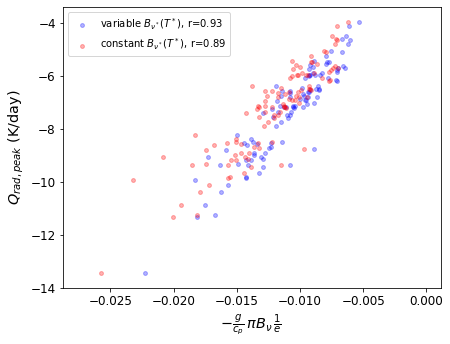

In [116]:
fig,ax = plt.subplots(figsize=(7,5))

ax.scatter(xdata,ydata,s=15,c='b',alpha=0.3,label=r'variable $B_{\nu^*}(T^*)$, r=%1.2f'%rvalue)
ax.scatter(xdata_constant_B,ydata,s=15,c='r',alpha=0.3,label=r'constant $B_{\nu^*}(T^*)$, r=%1.2f'%rvalue_constB)
ax.set_xlabel(r'$-\frac{g}{c_p}\, \frac{\beta}{p}\pi B_{\nu}\,\frac{1}{e}$ ')
ax.set_ylabel(r'$Q_{rad,peak}$ (K/day)')
ax.legend()